In [3]:
import sys
sys.path.append('/home/johann/sonstiges/comma10k-segmenation-pytorch')

import os 
import cv2 
import json
import albumentations as A 
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
from dataset import Comma10kDataset, train_test_split, get_test_transforms
import matplotlib.pyplot as plt 

In [31]:
exp_dir = "/home/johann/sonstiges/comma10k-segmenation-pytorch/exps/2022-04-08"

In [32]:
stats_filepath = os.path.join(exp_dir, "train_stats.json")

In [33]:
with open(stats_filepath, 'r') as fp:
    stats = json.load(fp)

In [34]:
stats['train'].keys()

dict_keys(['loss', 'iou_score', 'f1_score', 'accuracy', 'recall'])

In [43]:
train_loss = [v for _, v in stats['train']['loss'].items()]
train_ious = [v for _, v in stats['train']['iou_score'].items()]
train_f1 = [v for _, v in stats['train']['f1_score'].items()]
train_acc = [v for _, v in stats['train']['accuracy'].items()]
train_recall = [v for _, v in stats['train']['recall'].items()]
len(train_loss)

9271

In [44]:
smoothing_window = 20
windows = len(train_loss) // smoothing_window
windows

463

In [45]:
sm_train_loss = [sum(train_loss[i*smoothing_window:(i+1) * smoothing_window]) / smoothing_window 
                 for i in range(windows)]
sm_iters = [i*smoothing_window for i in range(windows)]
len(sm_iters)

463

In [52]:
def smoothing(vals: list, window_size: int = 50):
    num_windows = len(vals) // window_size
    nvals = [sum(vals[i*window_size :(i+1) * window_size]) / window_size 
                 for i in range(num_windows)]
    steps = [i*window_size for i in range(num_windows)]
    
    if len(vals) % window_size != 0:
        last = sum(vals[num_windows * window_size:]) / len(vals[num_windows * window_size:])
        nvals.append(last)
        steps.append(len(vals) - 1)
    
    return nvals, steps

In [53]:
sm_train_loss, train_steps = smoothing(train_loss)
sm_train_ious, _ = smoothing(train_ious)
sm_train_f1, _ = smoothing(train_f1)
sm_train_acc, _ = smoothing(train_acc)
sm_train_recall, _ = smoothing(train_recall)

In [54]:
len(train_steps)

186

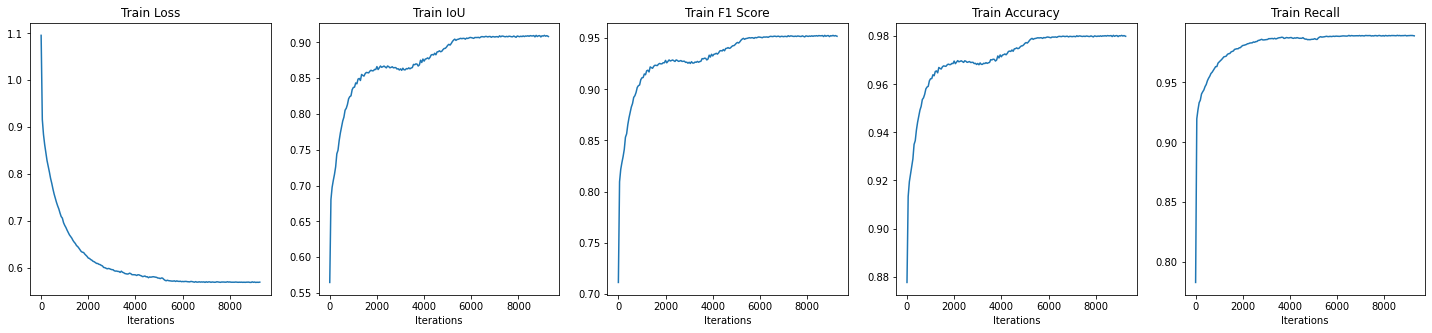

In [59]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
axs[0].plot(train_steps, sm_train_loss)
axs[0].set_title('Train Loss')
axs[0].set_xlabel('Iterations')
axs[1].plot(train_steps, sm_train_ious)
axs[1].set_title('Train IoU')
axs[1].set_xlabel('Iterations')
axs[2].plot(train_steps, sm_train_f1)
axs[2].set_title('Train F1 Score')
axs[2].set_xlabel('Iterations')
axs[3].plot(train_steps, sm_train_acc)
axs[3].set_title('Train Accuracy')
axs[3].set_xlabel('Iterations')
axs[4].plot(train_steps, sm_train_recall)
axs[4].set_title('Train Recall')
axs[4].set_xlabel('Iterations')
plt.show()

In [15]:
val_loss = [v for _, v in stats['val']['loss'].items()]
val_ious = [v for _, v in stats['val']['iou_score'].items()]
val_f1 = [v for _, v in stats['val']['f1_score'].items()]
val_acc = [v for _, v in stats['val']['accuracy'].items()]
val_recall = [v for _, v in stats['val']['recall'].items()]
len(val_loss)

6182

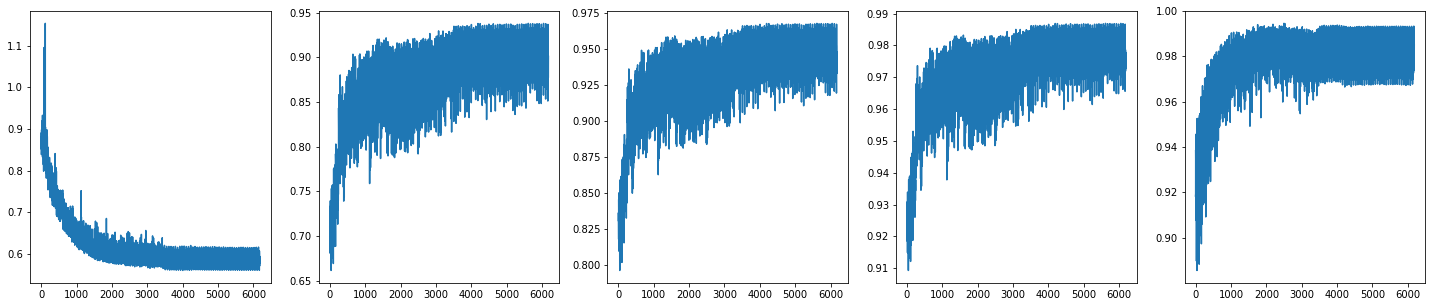

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
axs[0].plot(val_loss)
axs[1].plot(val_ious)
axs[2].plot(val_f1)
axs[3].plot(val_acc)
axs[4].plot(val_recall)
plt.show()

# Test Augmentations

In [39]:
comma10k_dir = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k"
imgs_root = os.path.join(comma10k_dir, "imgs")
masks_root = os.path.join(comma10k_dir, "masks")
classes = [41, 76, 90, 124, 161]

In [72]:
train_imgs, test_imgs = train_test_split(imgs_root)

In [73]:
image = test_imgs[0]

In [74]:
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

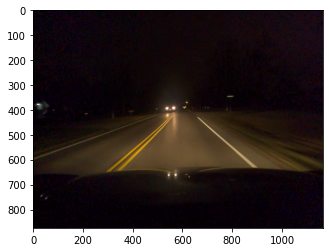

In [75]:
plt.imshow(img)

In [76]:
mask_path = os.path.join(masks_root, os.path.split(image)[1])

In [77]:
mask = cv2.imread(mask_path, 0).astype('uint8')

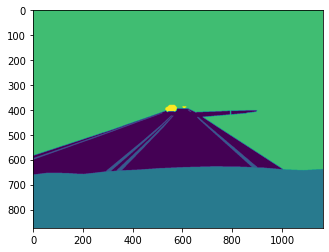

In [78]:
plt.imshow(mask)

In [79]:
mask = np.stack([(mask == v) for v in classes], axis=0)

In [80]:
mask.shape

(5, 874, 1164)

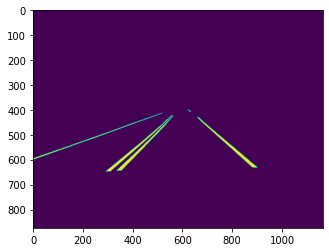

In [81]:
plt.imshow(mask[1])

In [82]:
transforms = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=0.75),
    ToTensorV2(p=1.0)
])

In [83]:
masks = [mask[i] for i in range(mask.shape[0])]

In [84]:
transformed = transforms(image=img, masks=masks)
transformed_img = transformed['image']
transformed_mask = transformed['masks']

In [89]:
np_masks = np.stack(transformed_mask, axis=0)
np_masks.shape

(5, 874, 1164)

In [90]:
tmasks = torch.tensor(np_masks)

In [92]:
tmasks.size()

torch.Size([5, 874, 1164])

transformed_mask.shape

In [12]:
test_dataset = Comma10kDataset(imgs_root, masks_root, test_imgs, classes, get_test_transforms())

In [21]:
for img, mask in test_dataset:
    print(img.size())
    print(mask.size())
    break

torch.Size([3, 448, 576])
torch.Size([5, 448, 576])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


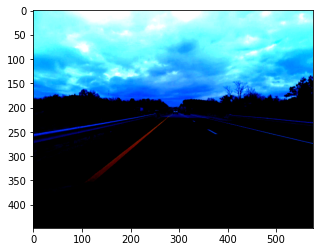

In [22]:
img = torch.transpose(img, 0, 2)
img = torch.transpose(img, 0, 1).numpy()
plt.imshow(img)

In [23]:
mask = mask.numpy()

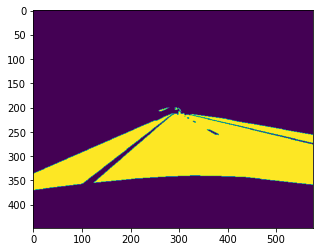

In [24]:
plt.imshow(mask[0])

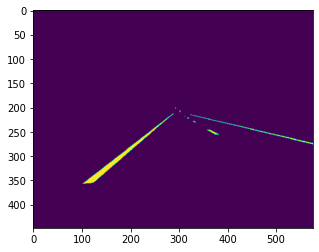

In [25]:
plt.imshow(mask[1])

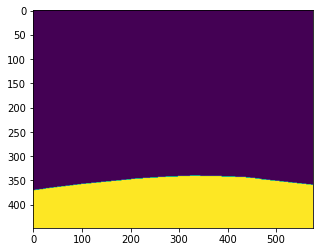

In [26]:
plt.imshow(mask[2])

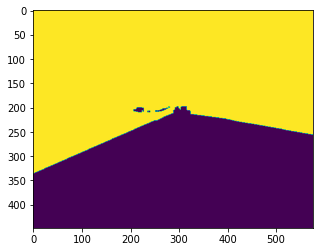

In [27]:
plt.imshow(mask[3])

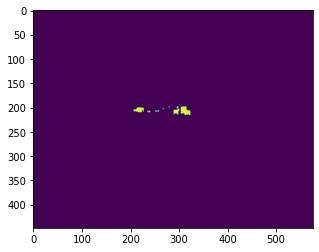

In [28]:
plt.imshow(mask[4])

# Test Model

In [2]:
import os 
import cv2
import random 
import glob 
import torch 
import torch.nn.functional as F
import numpy as np
from model import RegSeg
import matplotlib.pyplot as plt 

from PIL import ImageColor

import albumentations as A 
from albumentations.pytorch import ToTensorV2
from config import get_cfg_defaults 


In [3]:
imgs_folder = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs"
masks_folder = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/masks"
checkpoint = "/home/johann/sonstiges/comma10k-segmenation-pytorch/exps/2022-04-06/weights/best.pth"
classes = [41, 76, 90, 124, 161]

In [4]:
cfg = get_cfg_defaults()
cfg.merge_from_file("/home/johann/sonstiges/comma10k-segmenation-pytorch/exps/2022-04-06/config.yaml")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = RegSeg(num_classes=len(classes))
if cfg.SYSTEM.NUM_GPUS > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(checkpoint))
model.to(device)

DataParallel(
  (module): RegSeg(
    (encoder): Encoder(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (d_block_1_4): DBlock(
        (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
        (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu3): ReLU(inplace=True)
        (conv4): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1))
        (bn4): BatchNorm2d(48, 

In [7]:
model.eval()

DataParallel(
  (module): RegSeg(
    (encoder): Encoder(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (d_block_1_4): DBlock(
        (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
        (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu3): ReLU(inplace=True)
        (conv4): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1))
        (bn4): BatchNorm2d(48, 

In [8]:
transform = A.Compose([
    A.Resize(height=14*32, width=18*32), #height, width
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

In [9]:
test_imgs = glob.glob(imgs_folder + "/*.png")
samples = random.sample(test_imgs, 5)
for sample in samples:
    print(sample)

/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/1761_bc5b0834b1cc2cf0_2018-09-02--20-49-01_7_493.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/5814_b8727c7398d117f5_2019-03-06--08-34-45_25_724.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/h525_cf95f46f8b107413_2019-06-06--10-07-31_66_428.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/h563_b08af3f7380a4006_2019-01-17--18-01-04_2_274.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/3063_4b4d680748b83961_2018-09-18--10-14-13_16_505.png


In [10]:
def predict(model, img_path, transforms, device):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed_img = transforms(image=img)["image"]
    transformed_img = transformed_img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(transformed_img)
    
    pred = torch.sigmoid(pred)
    pred = pred.detach().cpu().squeeze().numpy()
    
    return pred

In [11]:
pred_0 = predict(model, samples[0], transform, device)

In [12]:
pred_m = (pred_0 > .5)
pred_m.shape

(5, 448, 576)

In [13]:
npred = np.multiply(pred_0, pred_m)
npred.shape

(5, 448, 576)

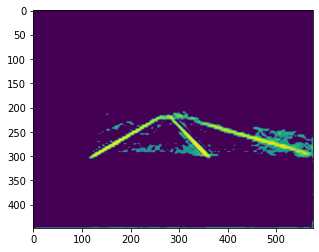

In [16]:
plt.imshow(npred[1])

In [17]:
channel2color = {
    0: "#402020",
    1: "#ff0000",
    2: "#cc00ff",
    3: "#808060",
    4: "#00ff66",
}

In [18]:
channel2class = {
    0: "road",
    1: "lane markings",
    2: "my car",
    3: "undrivable",
    4: "movable",
}

In [19]:
class_names = [
    "road",
    "lane markings",
    "undrivable",
    "movable",
    "my car"
]

In [20]:
hex_colors = [
    "#402020",
    "#ff0000",
    "#808060",
    "#00ff66",
    "#cc00ff",
]

In [21]:
rgb_colors = [list(ImageColor.getcolor(color, "RGB")) 
                   for color in list(channel2color.values())]
rgb_colors               

[[64, 32, 32], [255, 0, 0], [204, 0, 255], [128, 128, 96], [0, 255, 102]]

In [22]:
rgb_colors = np.array(rgb_colors).astype("uint8")

In [23]:
def plot_segmentation(
    model, 
    img_path, 
    classes,
    colors,
    transforms, 
    device, 
    figsize=(16,9),
    img_weight=0.5,
):
    pred = predict(model, img_path, transforms, device)
    classMap = np.argmax(pred, axis=0)
    print(classMap.shape)
    colored_mask = colors[classMap]
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    colored_mask = cv2.resize(
        colored_mask, 
        (image.shape[1], image.shape[0]), 
        interpolation=cv2.INTER_NEAREST,
    )
    
    output = ((img_weight * image) + ((1. - img_weight) * colored_mask)).astype("uint8")
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(output)

(448, 576)


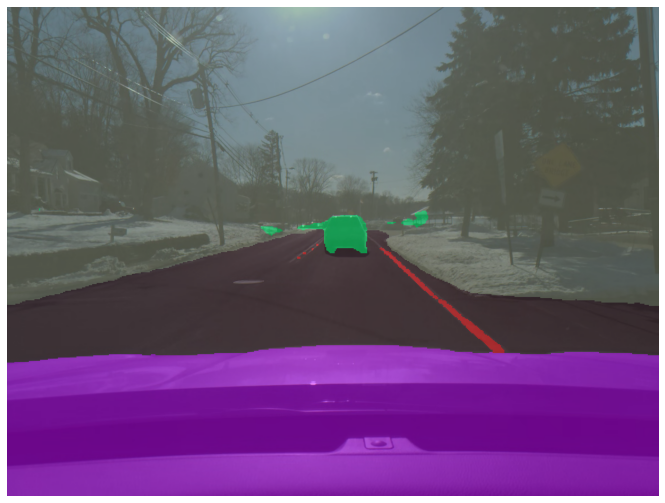

In [24]:
plot_segmentation(
    model, 
    samples[1], 
    classes, 
    rgb_colors, 
    transform, 
    device,
)

(448, 576)


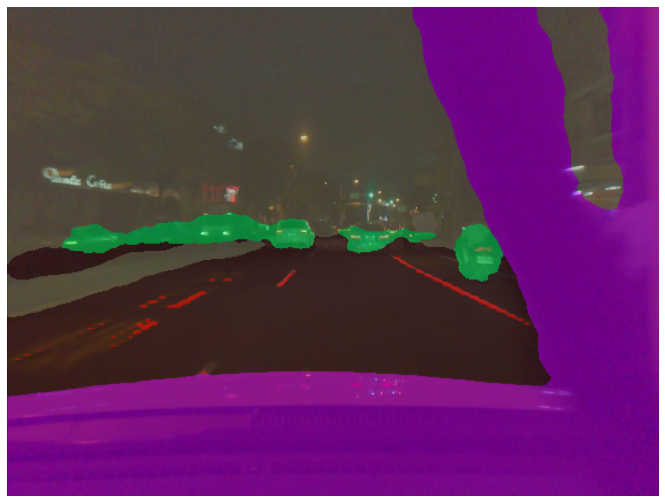

In [25]:
plot_segmentation(
    model, 
    samples[2], 
    classes, 
    rgb_colors, 
    transform, 
    device,
)

(448, 576)


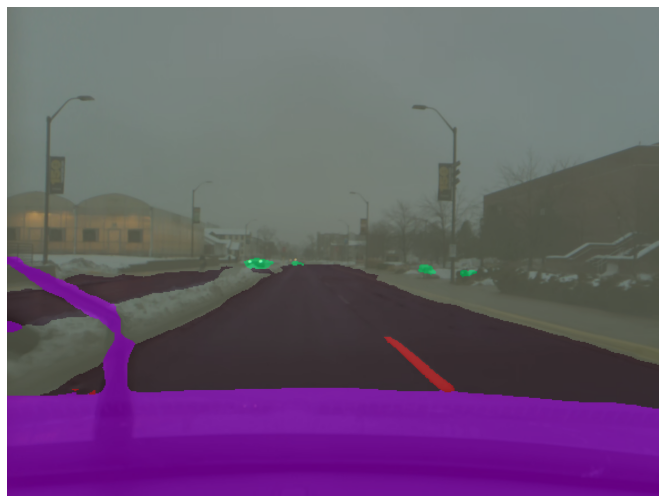

In [26]:
plot_segmentation(
    model, 
    samples[3], 
    classes, 
    rgb_colors, 
    transform, 
    device,
)

(448, 576)


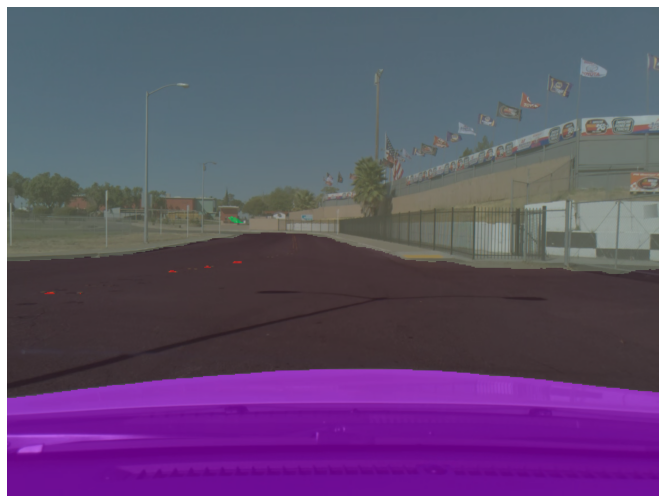

In [27]:
plot_segmentation(
    model, 
    samples[4], 
    classes, 
    rgb_colors, 
    transform, 
    device,
)

In [28]:
def plot_pred2tgt(
    model, 
    img_path, 
    classes,
    colors,
    transforms, 
    device,
    masks_folder,
    outname="/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example.jpg",
    figsize=(12,5),
    img_weight=0.5,
):
    _, filename = os.path.split(img_path)
    mask_path = os.path.join(masks_folder, filename)
    
    pred = predict(model, img_path, transforms, device)
    classMap = np.argmax(pred, axis=0)
    
    colored_mask = colors[classMap]
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    tgt_mask = cv2.imread(mask_path)
    tgt_mask = cv2.cvtColor(tgt_mask, cv2.COLOR_BGR2RGB)
    
    colored_mask = cv2.resize(
        colored_mask, 
        (image.shape[1], image.shape[0]), 
        interpolation=cv2.INTER_NEAREST,
    )
    
    output = ((img_weight * image) + ((1. - img_weight) * colored_mask)).astype("uint8")
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
   
    axs[0].imshow(output)
    axs[0].set_title('Prediction')
    axs[0].axis('off')
    axs[1].imshow(tgt_mask)
    axs[1].set_title('Groundtruth')
    axs[1].axis('off')
    fig.tight_layout()
    plt.show()
    fig.savefig(outname)

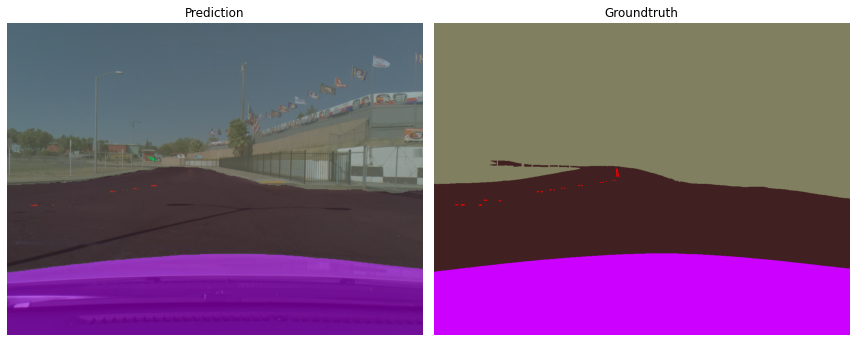

In [29]:
plot_pred2tgt(
    model, 
    samples[4], 
    classes, 
    rgb_colors, 
    transform, 
    device,
    masks_folder,
    "/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example-0.jpg",
)

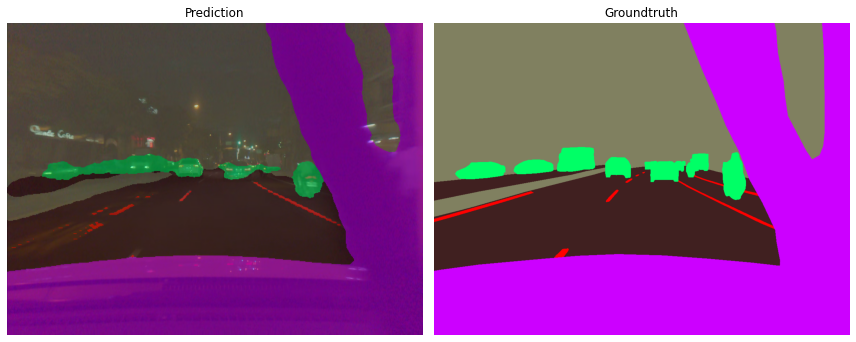

In [30]:
plot_pred2tgt(
    model, 
    samples[2], 
    classes, 
    rgb_colors, 
    transform, 
    device,
    masks_folder,
    "/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example-1.jpg"
)

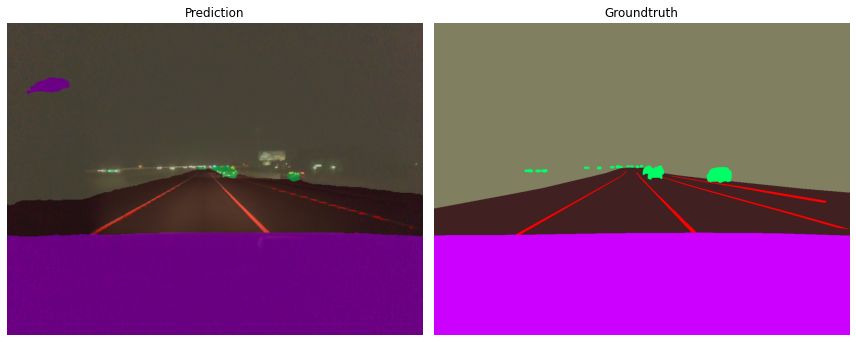

In [31]:
plot_pred2tgt(
    model, 
    samples[0], 
    classes, 
    rgb_colors, 
    transform, 
    device,
    masks_folder,
    "/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example-2.jpg"
)

# Evaluation

In [38]:
imgs_folder = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs"
masks_folder = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/masks"
checkpoint = "/home/johann/sonstiges/comma10k-segmenation-pytorch/exps/2022-04-06/weights/best.pth"
classes = [41, 76, 90, 124, 161]

In [39]:
test_imgs = glob.glob(imgs_folder + "/*.png")
samples = random.sample(test_imgs, 5)
for sample in samples:
    print(os.path.split(sample)[1])

8368_052a0713d2d1efa6_2018-11-19--21-49-45_7_171.png
h649_74e8e64805193af8_2018-10-05--22-27-34_7_354.png
2330_b4f4fe3c14aa1e3b_2018-10-29--03-19-49_36_1190.png
6770_cf95f46f8b107413_2019-04-22--10-19-08_52_1023.png
8074_e063bf27334a0d2a_2019-05-28--03-24-46_2_357.png


In [40]:
import segmentation_models_pytorch as smp

In [41]:
img_path = samples[0]
_, filename = os.path.split(img_path)
mask_path = os.path.join(masks_folder, filename)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transformed_img = transform(image=img)["image"]
transformed_img = transformed_img.unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(transformed_img)

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tgt_mask = cv2.imread(mask_path, 0).astype("uint8")
tgt_mask = cv2.resize(tgt_mask, (pred.size()[3], pred.size()[2]))

tgt_mask = torch.tensor(tgt_mask).long()
mask = torch.stack([(tgt_mask == v) for v in classes], axis=0).unsqueeze(0)

In [42]:
pred.size()

torch.Size([1, 5, 448, 576])

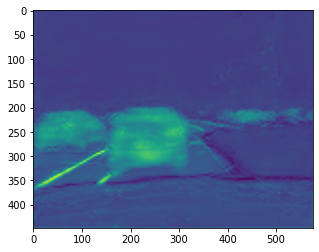

In [43]:
plt.imshow(pred.squeeze().cpu().numpy()[1])

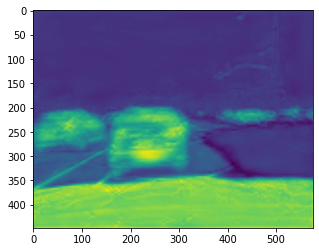

In [44]:
plt.imshow(pred.squeeze().cpu().numpy()[2])

In [45]:
mask.size()

torch.Size([1, 5, 448, 576])

In [46]:
pred = pred.cpu()

In [47]:
tp, fp, fn, tn = smp.metrics.get_stats(
    pred, mask, mode='multilabel', threshold=0.5)

In [48]:
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
iou_score

tensor(0.6580)

In [49]:
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
f1_score

tensor(0.7937)

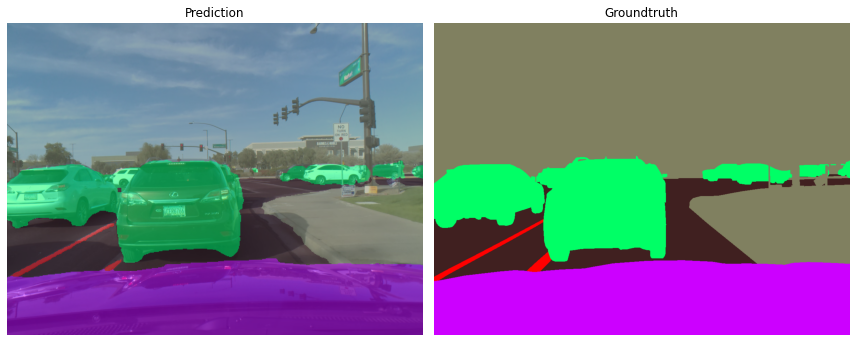

In [50]:
plot_pred2tgt(
    model, 
    samples[0], 
    classes, 
    rgb_colors, 
    transform, 
    device,
    masks_folder,
    "/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example-2.jpg"
)

In [51]:
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
accuracy

tensor(0.8971)

In [52]:
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
recall

tensor(0.9963)